In [468]:
from collections import defaultdict
# Classes
class Individual:
    def __init__(self, ind_id):
        self.id = ind_id
        self.vcf_index = None
        self.autism_status = None
        self.sex = None

    def __repr__(self):
        return '%s' % self.id

class Family:

    def __init__(self):
        self.parents_to_children = defaultdict(list) # (mother_id, father_id) -> [child1, child2, ...]
        self.members = {}

    def add_trio(self, child_id, mother_id, father_id, child_autism_status, child_sex):
        if child_id not in self.members:
            self.members[child_id] = Individual(child_id)
            self.members[child_id].autism_status = child_autism_status
            self.members[child_id].sex = child_sex
        child = self.members[child_id]
        if mother_id not in self.members:
            self.members[mother_id] = Individual(mother_id)
        mother = self.members[mother_id]
        if father_id not in self.members:
            self.members[father_id] = Individual(father_id)
        father = self.members[father_id]

        self.parents_to_children[(mother_id, father_id)].append(child_id)

    def add_vcf_index(self, ind_id, vcf_index):
        if ind_id in self.members:
            self.members[ind_id].vcf_index = vcf_index
            
    def get_ordered_member_ids(self):
        ordered_member_ids = []
        for (mother_id, father_id), child_ids in self.parents_to_children.items():
            ordered_member_ids.extend([mother_id, father_id] + child_ids)
        ordered_member_ids = [x for x in ordered_member_ids if self.members[x].vcf_index is not None]
        return ordered_member_ids

    def get_info(self):
        ordered_member_ids = self.get_ordered_member_ids()
        return [(self.members[ind_id].autism_status, self.members[ind_id].sex) for ind_id in ordered_member_ids]
    
    def get_vcf_indices(self):
        ordered_member_ids = self.get_ordered_member_ids()
        return [self.members[ind_id].vcf_index for ind_id in ordered_member_ids if self.members[ind_id].vcf_index is not None]

In [469]:
import numpy as np

# Mappings
phase_map = {
    (0, 0, 0): (0, 0, 0, 0),
    (0, 0, 1): (-1, -1, -1, -1), # non-mendelian
    (0, 0, 2): (-1, -1, -1, -1), # non-mendelian
    (0, 1, 0): (0, 0, 0, 1),
    (0, 1, 1): (0, 0, 1, 0),
    (0, 1, 2): (-1, -1, -1, -1), # non-mendelian
    (0, 2, 0): (-1, -1, -1, -1), # non-mendelian
    (0, 2, 1): (0, 0, 1, 1),
    (0, 2, 2): (-1, -1, -1, -1), # non-mendelian
    (1, 0, 0): (0, 1, 0, 0),
    (1, 0, 1): (1, 0, 0, 0),
    (1, 0, 2): (-1, -1, -1, -1), # non-mendelian
    (1, 1, 0): (0, 1, 0, 1),
    (1, 1, 1): (-1, -1, -1, -1), # unknown phase
    (1, 1, 2): (1, 0, 1, 0),
    (1, 2, 0): (-1, -1, -1, -1), # non-mendelian
    (1, 2, 1): (0, 1, 1, 1),
    (1, 2, 2): (1, 0, 1, 1),
    (2, 0, 0): (-1, -1, -1, -1), # non-mendelian
    (2, 0, 1): (1, 1, 0, 0),
    (2, 0, 2): (-1, -1, -1, -1), # non-mendelian
    (2, 1, 0): (-1, -1, -1, -1), # non-mendelian
    (2, 1, 1): (1, 1, 0, 1),
    (2, 1, 2): (1, 1, 1, 0),
    (2, 2, 0): (-1, -1, -1, -1), # non-mendelian
    (2, 2, 1): (-1, -1, -1, -1), # non-mendelian
    (2, 2, 2): (1, 1, 1, 1),
}

mt_phase_map = {
    (0, 0, 0): (0, 0),
    (0, 0, 1): (-1, -1), # non-mendelian
    (0, 0, 2): (-1, -1), # non-mendelian
    (0, 1, 0): (-1, -1), # hetero
    (0, 1, 1): (-1, -1), # hetero
    (0, 1, 2): (-1, -1), # hetero
    (0, 2, 0): (0, 1),
    (0, 2, 1): (-1, -1), # hetero
    (0, 2, 2): (-1, -1), # non-mendelian
    (1, 0, 0): (-1, -1), # hetero
    (1, 0, 1): (-1, -1), # hetero
    (1, 0, 2): (-1, -1), # hetero
    (1, 1, 0): (-1, -1), # hetero
    (1, 1, 1): (-1, -1), # hetero
    (1, 1, 2): (-1, -1), # hetero
    (1, 2, 0): (-1, -1), # hetero
    (1, 2, 1): (-1, -1), # hetero
    (1, 2, 2): (-1, -1), # hetero
    (2, 0, 0): (-1, -1), # non-mendelian
    (2, 0, 1): (-1, -1), # hetero
    (2, 0, 2): (1, 0),
    (2, 1, 0): (-1, -1), # hetero
    (2, 1, 1): (-1, -1), # hetero
    (2, 1, 2): (-1, -1), # hetero
    (2, 2, 0): (-1, -1), # non-mendelian
    (2, 2, 1): (-1, -1), # hetero
    (2, 2, 2): (1, 1),
}


In [470]:
# load data
import time
import gzip
import matplotlib.pyplot as plt

# Pull arguments
#vcf_file = 'AU0678.ms1.22.vcf.gz'
vcf_file = 'v34.MT.vcf.gz'
ped_file = 'v34.forCompoundHet.ped'

start_time = time.time()

# Pull family structure from ped file
families = {}
member_to_family = {}
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, father_id, mother_id = pieces[0:4]
        if fam_id not in families:
            families[fam_id] = Family()
        families[fam_id].add_trio(child_id, mother_id, father_id, 
                                  'Autism' if pieces[5]=='2' else 'Control', 
                                  'Male' if pieces[4]=='1' else 'Female')
        member_to_family[child_id] = fam_id
        member_to_family[mother_id] = fam_id
        member_to_family[father_id] = fam_id
print('Num families:', len(families))

# Pull data from vcf
with gzip.open(vcf_file, 'rt') as f:
    line = next(f)
    while line.startswith('##'):
        line = next(f)

    # Pull header and add vcf indices
    pieces = line.strip().split('\t')
    for i, ind_id in enumerate(pieces[9:]):
        if ind_id in member_to_family:
            families[member_to_family[ind_id]].add_vcf_index(ind_id, i)
    line = next(f)
    
    # Remove families not included in vcf
    families = dict([(i, x) for i, x in families.items() if len(x.get_vcf_indices()) > 0])
    print('Num families with genomic data:', len(families))
    
    # Load genotypes into numpy arrays
    n = len(pieces)-9
    gen_mapping = {b'./.': -1, b'0/0': 0, b'0/1': 1, b'1/0': 1, b'1/1': 2}
    converter = lambda gen:gen_mapping[gen[:3]]
    vcf_indices = range(9, n+9)
    data = np.loadtxt(f, dtype=np.int8, converters=dict(zip(vcf_indices, [converter]*n)), delimiter='\t', usecols=vcf_indices).T

print('Full dataset', data.shape)

Num families: 756
Num families with genomic data: 756
Full dataset (4610, 3615)


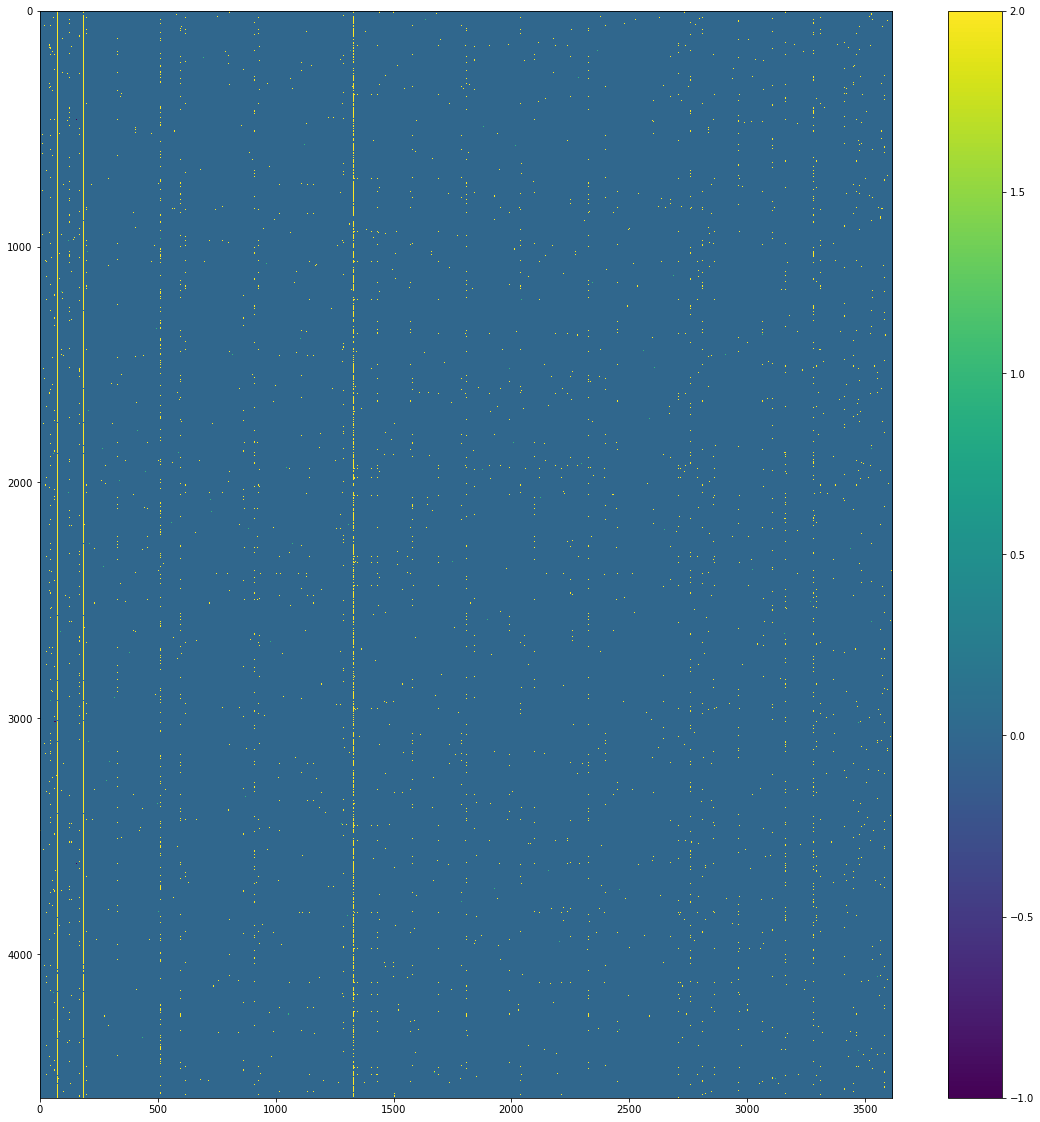

In [472]:
plt.figure(figsize=(20,20))
heatmap = plt.imshow(data)
plt.colorbar(heatmap)
plt.show()

Family AU0012 dataset (4, 3615)
defaultdict(<class 'list'>, {('AU001201', 'AU001202'): ['AU001203', 'AU001204']})
[(None, None), (None, None), ('Autism', 'Male'), ('Autism', 'Male')]
['AU001201', 'AU001202', 'AU001203', 'AU001204']


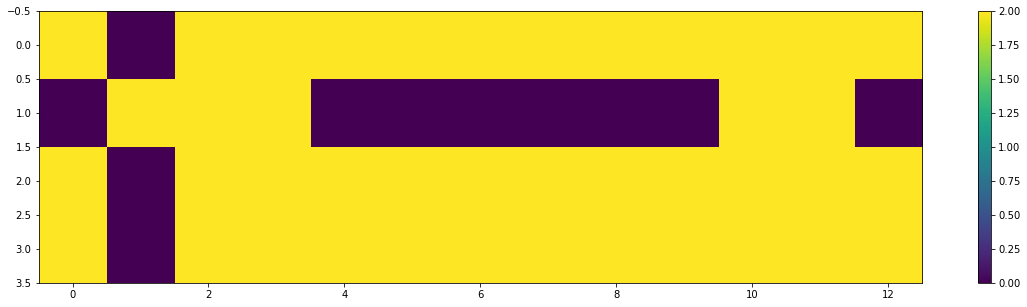

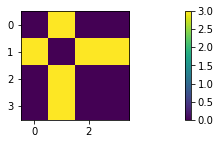

Family AU0021 dataset (5, 3615)
defaultdict(<class 'list'>, {('AU002101', 'AU002102'): ['AU002103', 'AU002105', 'AU002106']})
[(None, None), (None, None), ('Control', 'Male'), ('Autism', 'Male'), ('Autism', 'Male')]
['AU002101', 'AU002102', 'AU002103', 'AU002105', 'AU002106']


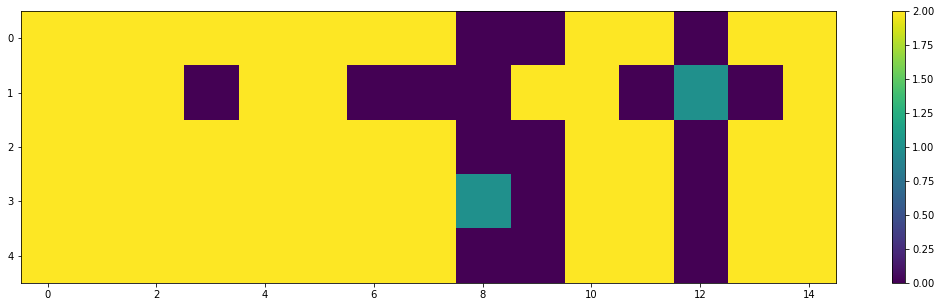

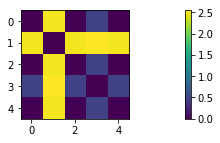

Family AU0025 dataset (12, 3615)
defaultdict(<class 'list'>, {('AU0025101', 'AU0025102'): ['AU002501', 'AU0025212'], ('AU002501', 'AU002502'): ['AU002503', 'AU002504'], ('AU002501', 'AU002506'): ['AU002505'], ('AU0025212', 'AU0025211'): ['AU0025311', 'AU0025312']})
[('Control', 'Female'), ('Control', 'Female'), ('Control', 'Female'), (None, None), ('Autism', 'Male'), ('Autism', 'Male'), ('Control', 'Female'), ('Control', 'Female'), ('Control', 'Female'), (None, None), ('Control', 'Female'), ('Autism', 'Female')]
['AU002501', 'AU0025212', 'AU002501', 'AU002502', 'AU002503', 'AU002504', 'AU002501', 'AU002505', 'AU0025212', 'AU0025211', 'AU0025311', 'AU0025312']


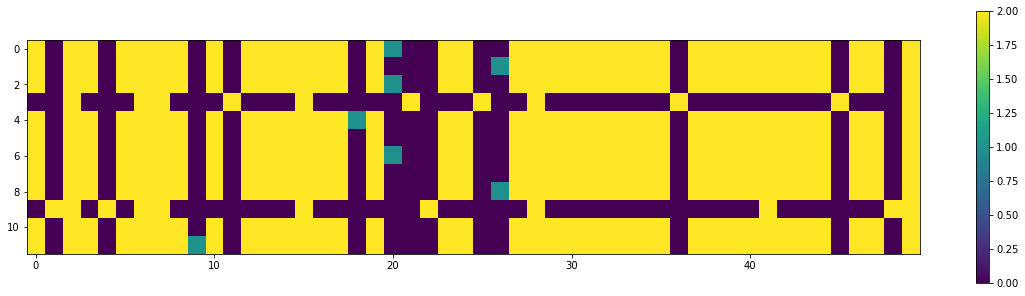

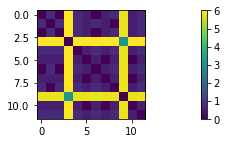

Family AU0028 dataset (5, 3615)
defaultdict(<class 'list'>, {('AU002801', 'AU002802'): ['AU002803', 'AU002804', 'AU002805']})
[(None, None), (None, None), ('Autism', 'Male'), ('Autism', 'Male'), ('Control', 'Female')]
['AU002801', 'AU002802', 'AU002803', 'AU002804', 'AU002805']


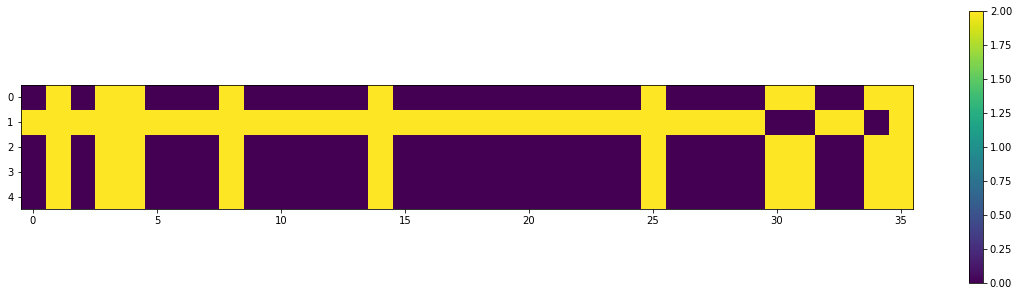

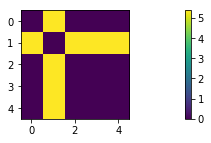

Family AU0030 dataset (4, 3615)
defaultdict(<class 'list'>, {('AU003001', 'AU003002'): ['AU003003', 'AU003004']})
[(None, None), (None, None), ('Autism', 'Male'), ('Autism', 'Male')]
['AU003001', 'AU003002', 'AU003003', 'AU003004']


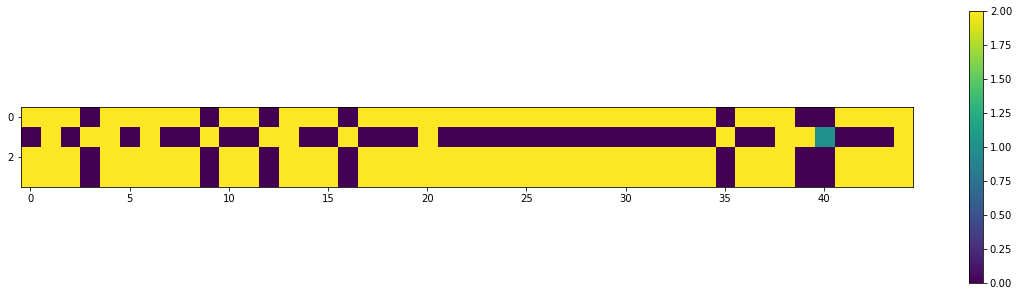

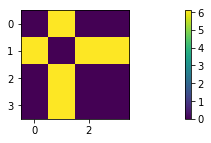

Family AU0033 dataset (6, 3615)
defaultdict(<class 'list'>, {('AU003301', 'AU003302'): ['AU003303', 'AU003304', 'AU003305', 'AU003306']})
[(None, None), (None, None), ('Autism', 'Male'), ('Autism', 'Female'), ('Control', 'Male'), ('Control', 'Male')]
['AU003301', 'AU003302', 'AU003303', 'AU003304', 'AU003305', 'AU003306']


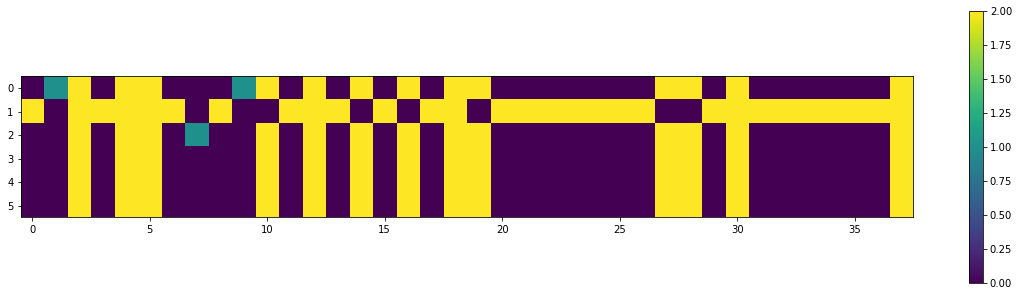

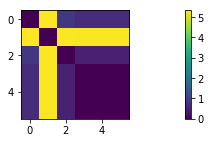

Family AU0037 dataset (5, 3615)
defaultdict(<class 'list'>, {('AU003701', 'AU003702'): ['AU003703', 'AU003704', 'AU003705']})
[(None, None), (None, None), ('Control', 'Female'), ('Autism', 'Male'), ('Autism', 'Male')]
['AU003701', 'AU003702', 'AU003703', 'AU003704', 'AU003705']


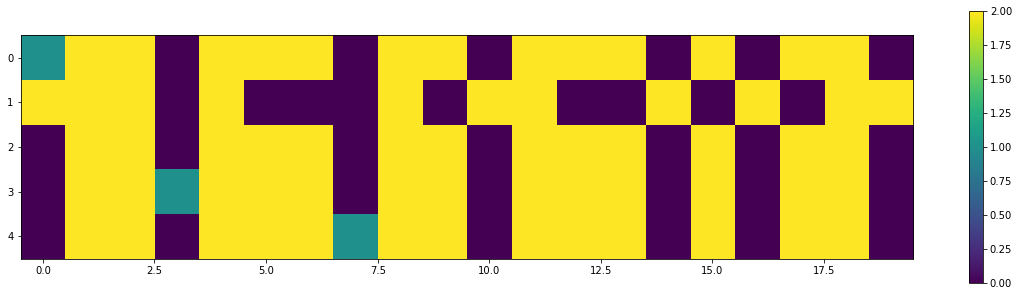

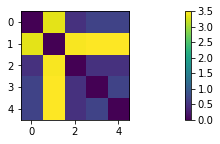

Family AU0041 dataset (5, 3615)
defaultdict(<class 'list'>, {('AU004101', 'AU004102'): ['AU004103', 'AU004104', 'AU004105']})
[(None, None), (None, None), ('Control', 'Female'), ('Autism', 'Female'), ('Autism', 'Female')]
['AU004101', 'AU004102', 'AU004103', 'AU004104', 'AU004105']


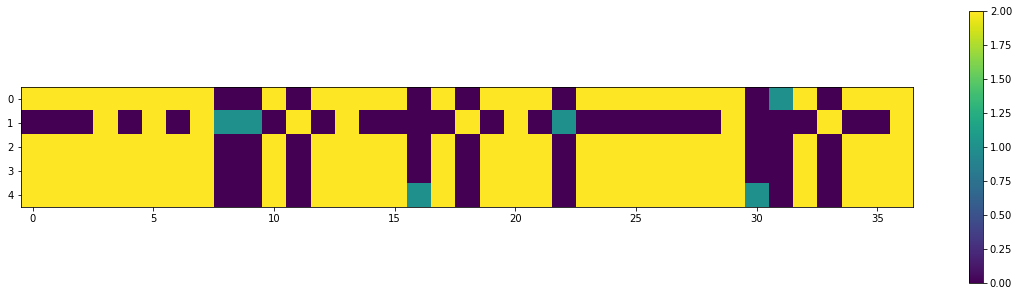

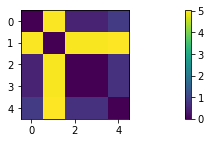

Family AU0043 dataset (5, 3615)
defaultdict(<class 'list'>, {('AU004301', 'AU004302'): ['AU004303', 'AU004304', 'AU004305']})
[(None, None), (None, None), ('Control', 'Female'), ('Autism', 'Male'), ('Autism', 'Male')]
['AU004301', 'AU004302', 'AU004303', 'AU004304', 'AU004305']


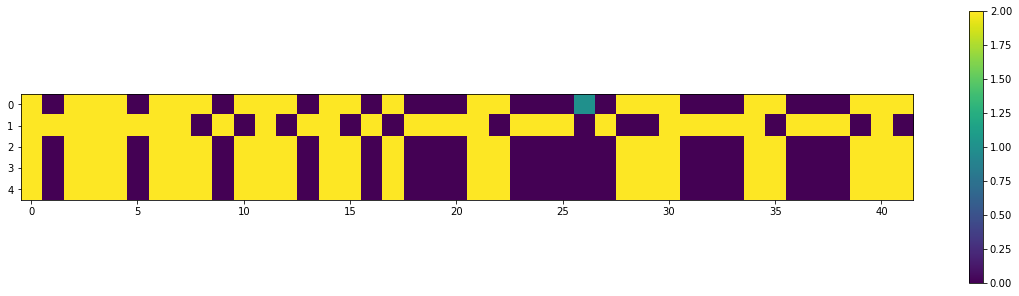

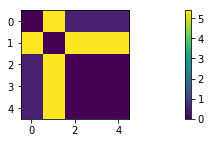

Family AU0048 dataset (4, 3615)
defaultdict(<class 'list'>, {('AU004801', 'AU004802'): ['AU004803', 'AU004804']})
[(None, None), (None, None), ('Autism', 'Male'), ('Autism', 'Male')]
['AU004801', 'AU004802', 'AU004803', 'AU004804']


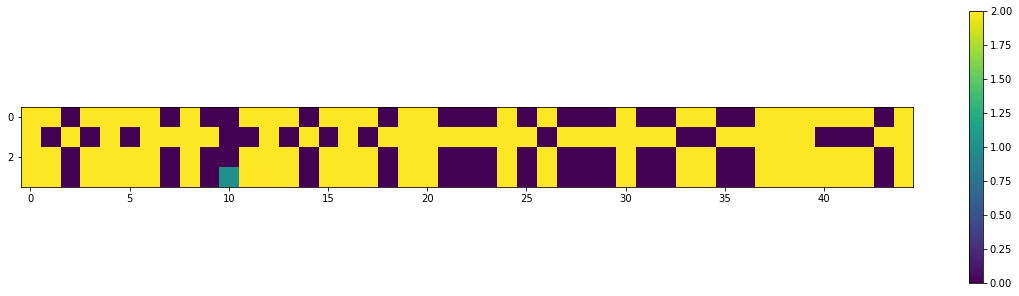

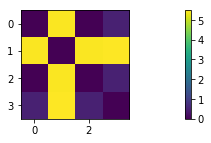

In [473]:
from sklearn.metrics.pairwise import euclidean_distances

for i in range(0, 10):
    family_id, family = list(families.items())[i]
    family_data = data[family.get_vcf_indices(), :]
    print('Family %s dataset' % family_id, family_data.shape)

    print(family.parents_to_children)
    print(family.get_info())
    print(family.get_ordered_member_ids())

    # Remove completely homozygous ref entries
    family_data = family_data[:, ~(family_data==0).all(axis=0)]
    #print('Remove homozygous ref entries', family_data.shape)

    # Remove rows with missing entries
    family_data = family_data[:, (family_data!=-1).all(axis=0)]
    #print('Remove missing entries', family_data.shape)

    plt.figure(figsize=(20,5))
    heatmap = plt.imshow(family_data)
    plt.colorbar(heatmap)
    plt.show()

    d = euclidean_distances(family_data/2, family_data/2)
    plt.figure(figsize=(20,2))
    heatmap = plt.imshow(d)
    plt.colorbar(heatmap)
    plt.show()

In [474]:
from itertools import product

def rough_phase(data, child_index=2, phase_map=phase_map):
    return np.apply_along_axis(lambda x: phase_map[(x[0], x[1], x[child_index])], 0, data)

def phase(data, X):
    m, _, n = X.shape
    all_combinations = np.array(list(product([0, 1], repeat=4))).T
    Y = np.zeros((4, n))
    for i in range(n):
        diff = np.outer(data[:, i], np.ones(all_combinations.shape[1])) - X[:, :, i].dot(all_combinations)
        index = np.argmin(np.sum(np.abs(diff), axis=0))
        Y[:, i] = all_combinations[:, index]

    return Y

def to_genotype(X, Y):
    m, _, n = X.shape
    genotype = np.zeros((m, n))
    for i in range(m):
        genotype[i, :] = np.sum(X[i, :, :]*Y, axis=0)
    return genotype

In [475]:
from itertools import product, islice

def detect_recombination(data, Y, switch_cost=50):
    m, n = data.shape
    X = np.zeros((m, 4, n))
    X[0, 0, :] = X[0, 1, :] = 1 # Mom always has m1, m2
    X[1, 2, :] = X[1, 3, :] = 1 # Dad always has p1, p2
    X[2, 0, :] = X[2, 2, :] = 1 # Child1 always has m1, p1
    
    # genotype possibilities for children
    # m1p1, m1p2, m2p1, m2p2
    Z = np.array([[1, 0, 1, 0], 
                  [1, 0, 0, 1], 
                  [0, 1, 1, 0], 
                  [0, 1, 0, 1]]).dot(Y)
    transition_costs = np.array([[0, 1, 1, 2],
                                 [1, 0, 2, 1],
                                 [1, 2, 0, 1],
                                 [2, 1, 1, 0]])*switch_cost
    index_to_indices = [(0, 2), (0, 3), (1, 2), (1, 3)]
    
    for i in range(3, m):
        # for each child
        
        # Forward sweep
        dp = [[(0, None)]*4]
        for j in range(n):
            gen = data[i, j]
            # consider cost of all 16 combinations
            possible_transitions = list(product(range(4), repeat=2))
            costs = [(dp[-1][k][0]+transition_costs[k, l]+abs(gen-Z[l, j]), k) for l, k in possible_transitions]
            dp.append([min(costs[:4]), min(costs[4:8]), min(costs[8:12]), min(costs[12:16])])
                
        #print(dp[:5])
        #print(dp[-5:])
        
        # Backward sweep
        index = n-1
        cost, prev = min(dp[index])
        X[i, index_to_indices[prev], index] = 1
        while prev is not None:
            X[i, index_to_indices[prev], index-1] = 1
            index -= 1
            _, prev = min(dp[index])
            
        #print(X[i, :, :])
    return X



In [476]:

Y0 = rough_phase(family_data)
X1 = detect_recombination(family_data, Y0, switch_cost=500)
Y1 = phase(family_data, X1)
X2 = detect_recombination(family_data, Y1, switch_cost=500)
Y2 = phase(family_data, X2)
#X3 = detect_recombination(family_data, Y2, switch_cost=50)
#Y3 = phase(family_data, X3)


In [477]:
print(X1.shape, Y1.shape)
print(X2.shape, Y2.shape)
print(X3.shape, Y3.shape)

(4, 4, 45) (4, 45)
(4, 4, 45) (4, 45)
(6, 4, 103938) (4, 103938)


In [478]:
m, n = family_data.shape
for j in range(m):
    print(j)
    maternal_recombinations = [0] + [i for i in range(n-1) if X3[j, 0, i] != X3[j, 0, i+1]] + [n-1]
    paternal_recombinations = [0] + [i for i in range(n-1) if X3[j, 2, i] != X3[j, 2, i+1]] + [n-1]
    print(maternal_recombinations)
    print(paternal_recombinations)

0
[0, 44]
[0, 44]
1
[0, 44]
[0, 44]
2
[0, 44]
[0, 44]
3
[0, 44]
[0, 44]


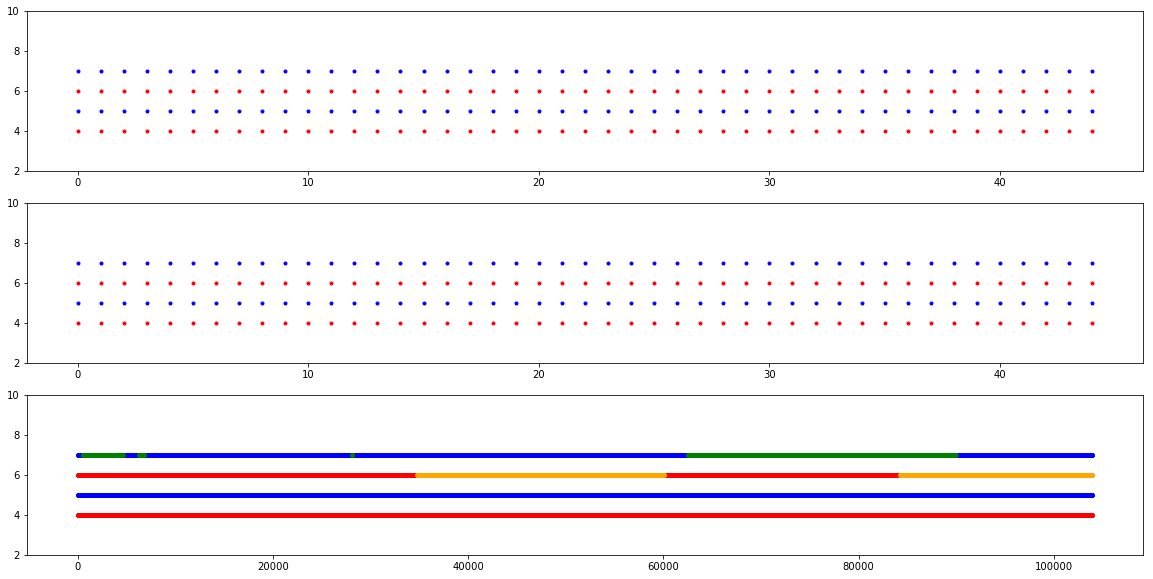

In [479]:
plt.figure(figsize=(20,10))

show = [X1, X2, X3]

for k, X in enumerate(show):
    plt.subplot(len(show), 1, k+1)
    for i in range(2, m):
        plt.plot(2*i*X[i, 0, :], linestyle='None', marker='.', color='red')
        plt.plot(2*i*X[i, 1, :], linestyle='None', marker='.', color='orange')
        plt.plot(2*i*X[i, 2, :]+1, linestyle='None', marker='.', color='blue')
        plt.plot(2*i*X[i, 3, :]+1, linestyle='None', marker='.', color='green')
    
    axes = plt.gca()
    axes.set_ylim([2,(m+1)*2])

plt.show()

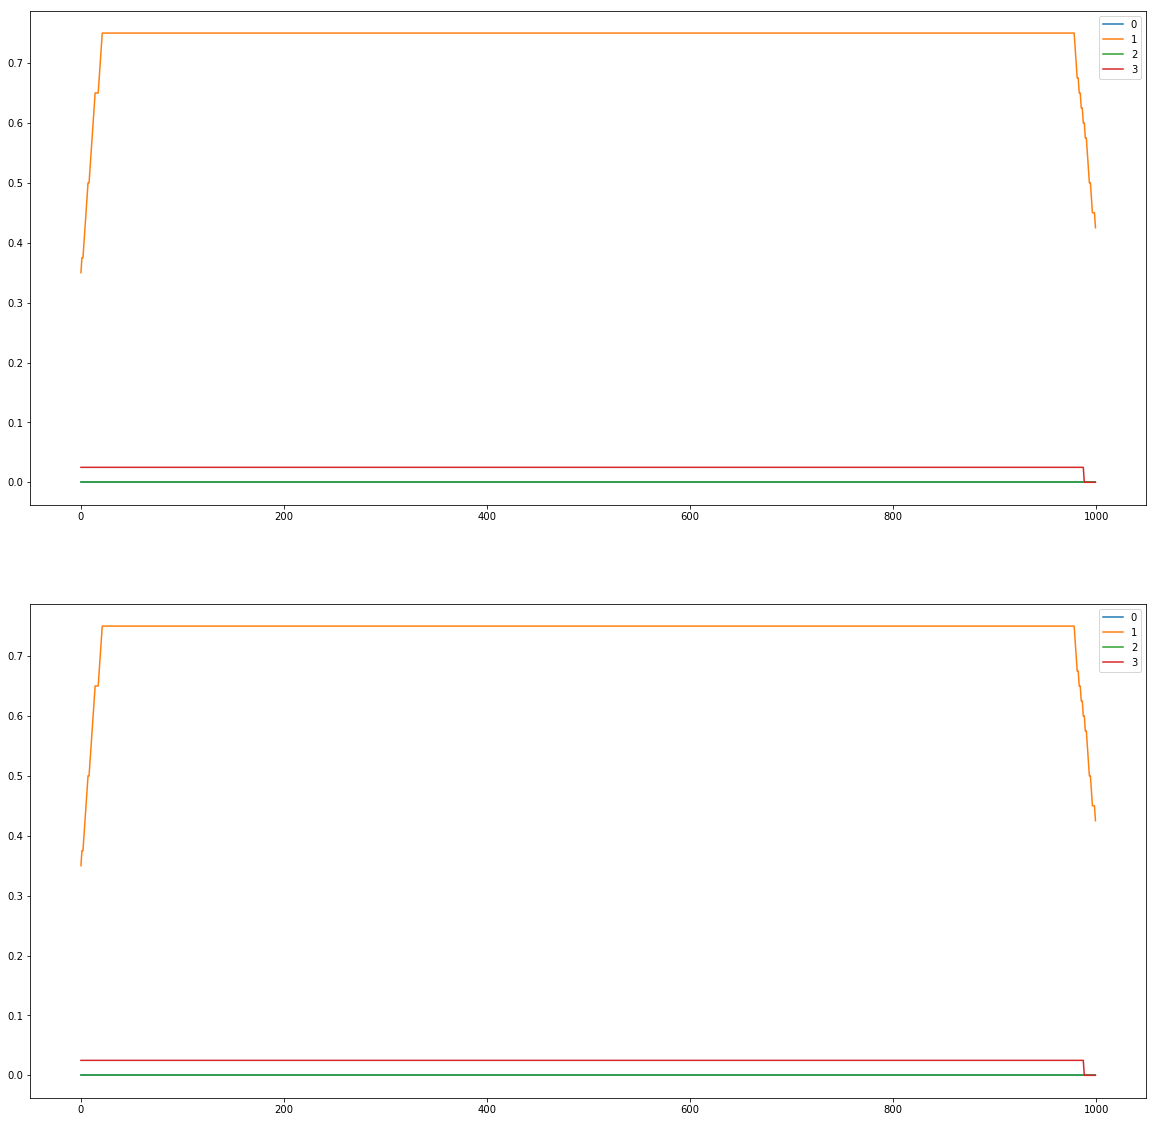

In [480]:
q = 1000
plt.figure(figsize=(20,20))

show = [(X1, Y1), (X2, Y2)]

for k, (X, Y) in enumerate(show):
    plt.subplot(len(show), 1, k+1)
    #plt.plot(np.convolve(np.sum(np.abs(to_genotype(X1, Y1)-data), axis=0)/m, np.ones((q,))/q, mode='same'))
    for i in range(m):
        plt.plot(np.convolve(np.abs(to_genotype(X, Y)-family_data)[i, :], np.ones((q,))/(m*10), mode='same'), label=str(i))
    axes = plt.gca()
    #axes.set_ylim([0, ])
    plt.legend()
plt.show()

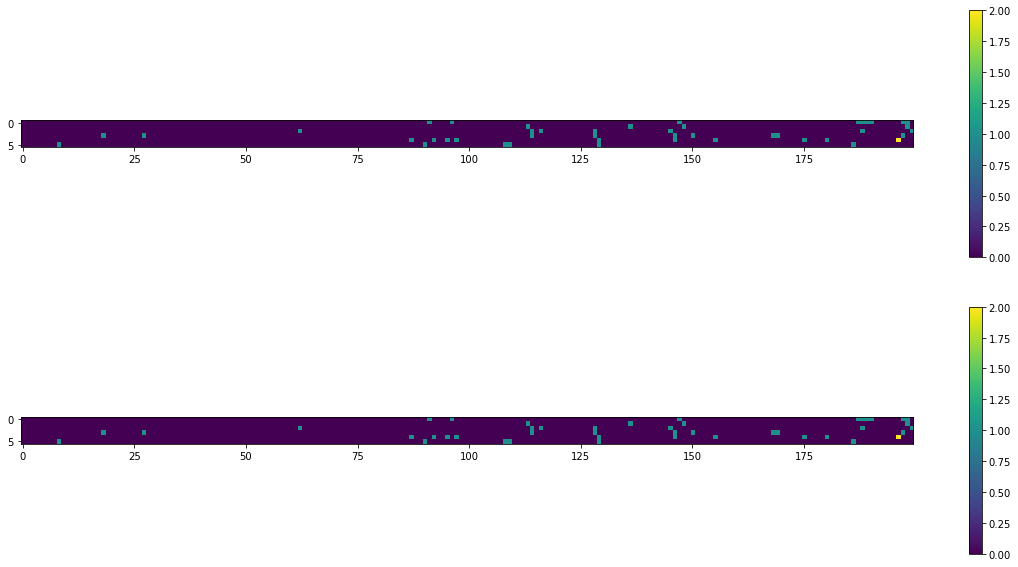

In [449]:
start, end = 70000, 70200
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
heatmap = plt.imshow(np.abs(to_genotype(X1, Y1)-family_data)[:, start:end])
plt.colorbar(heatmap)
plt.subplot(2, 1, 2)
heatmap = plt.imshow(np.abs(to_genotype(X2, Y2)-family_data)[:, start:end])
plt.colorbar(heatmap)
plt.show()